<a href="https://colab.research.google.com/github/chusshoo22/Chusshoo-24/blob/main/Brain_cancer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd


In [4]:
import numpy as np

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/brain-cancer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-cancer-mri-dataset


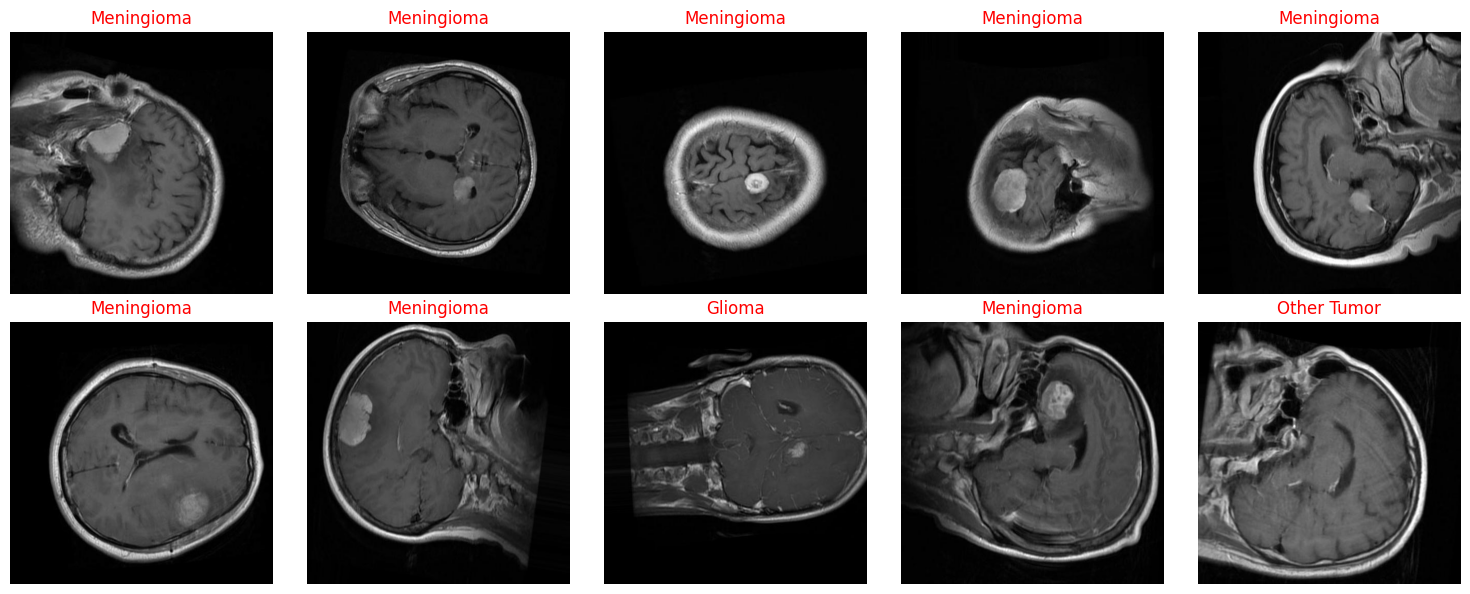

In [7]:
import os
import matplotlib.pyplot as plt
import random
import warnings

warnings.filterwarnings('ignore')


# Paths to the folders
image_folders = [
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma',
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_menin',
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor'
]

# Dictionary to map folder names to simpler labels
labels_mapping = {
    'brain_glioma': 'Glioma',
    'brain_menin': 'Meningioma',
    'brain_tumor': 'Other Tumor'
}

# List to hold the paths of all images and their labels
all_images = []

# Iterate through the folders, load image paths and labels
for folder in image_folders:
    label = labels_mapping[os.path.basename(folder)]
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Consider only image files
            image_path = os.path.join(folder, filename)
            all_images.append((image_path, label))

# Randomly select 10 images
num_images_to_show = 10
random_images = random.sample(all_images, min(num_images_to_show, len(all_images)))

# Display the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, (image_path, label) in enumerate(random_images):
    try:
        image = plt.imread(image_path)
        axes[i].imshow(image)
        axes[i].set_title(label, color='red')
        axes[i].axis('off')  # Hide the axes
    except Exception as e:
        print(f"Error loading image: {image_path} - {e}")

plt.tight_layout()
plt.show()

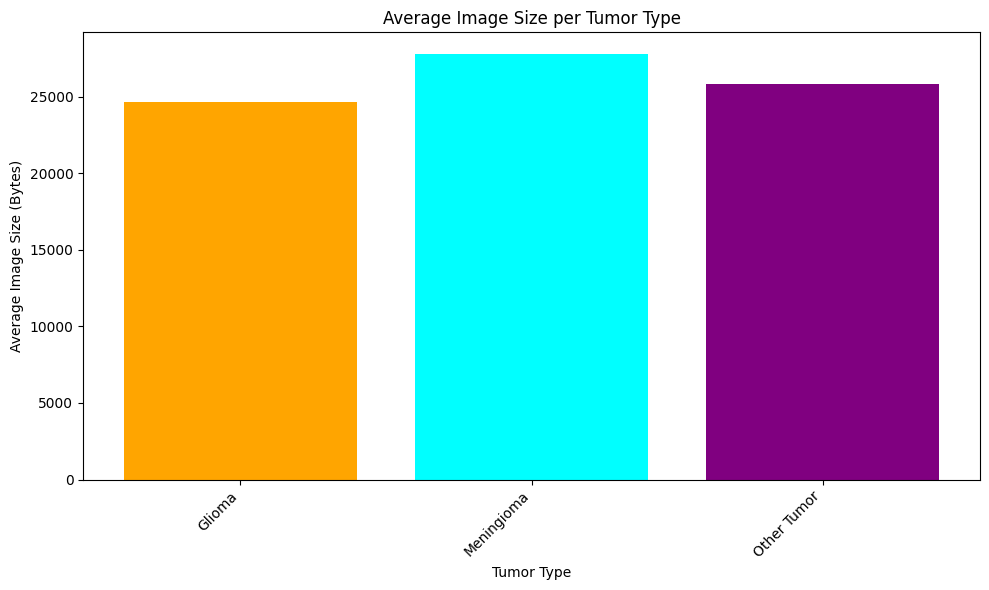

Average image size per label (in bytes):
Glioma: 24662.81 bytes
Meningioma: 27810.17 bytes
Other Tumor: 25806.67 bytes


In [8]:
label_sizes = {}
label_counts = {}
for label in labels_mapping.values():
    label_sizes[label] = 0
    label_counts[label] = 0

# Iterate through the folders, get image sizes, and update totals
for folder in image_folders:
    folder_label = labels_mapping[os.path.basename(folder)]
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder, filename)
            try:
                file_size_bytes = os.path.getsize(image_path)
                label_sizes[folder_label] += file_size_bytes
                label_counts[folder_label] += 1
            except FileNotFoundError:
                print(f"File not found: {image_path}")

# Calculate the average size per label
average_sizes = {}
for label in label_sizes:
    if label_counts[label] > 0:
        average_sizes[label] = label_sizes[label] / label_counts[label]
    else:
        average_sizes[label] = 0

# Create the bar chart for average image size
labels = list(average_sizes.keys())
avg_sizes = list(average_sizes.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, avg_sizes, color=['orange', 'cyan', 'purple'])
plt.xlabel('Tumor Type')
plt.ylabel('Average Image Size (Bytes)')
plt.title('Average Image Size per Tumor Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Average image size per label (in bytes):")
for label, avg_size in average_sizes.items():
    print(f"{label}: {avg_size:.2f} bytes")

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

image_folders = [
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma',
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_menin',
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor'
]
labels_mapping = {
    'brain_glioma': 'glioma',
    'brain_menin': 'meningioma',
    'brain_tumor': 'other_tumor'
}
class_names = list(labels_mapping.values())
num_classes = len(class_names)
image_size = (224, 224)
batch_size = 32
random_seed = 42
np.random.seed(random_seed)

images = []
labels = []
for folder in image_folders:
    label = labels_mapping[os.path.basename(folder)]
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            try:
                img = load_img(path, target_size=image_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image: {path} - {e}")

images = np.array(images, dtype='float32')
labels = np.array(labels)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    images, labels_categorical,
    test_size=0.2, stratify=labels_categorical,
    random_state=random_seed
)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weight_dict = dict(zip(range(num_classes), weights))
print("Class weights:", class_weight_dict)

# Augmentasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=random_seed)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False, seed=random_seed)

Class weights: {0: np.float64(1.0073186959414504), 1: np.float64(1.0073186959414504), 2: np.float64(0.9856770833333334)}


MODEL MİMARİSİ:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,267,011 (50.61 MB)

 Trainable params: 13,267,011 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

Toplam Parametre Sayısı: 13,267,011
Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 71s 403ms/step - accuracy: 0.5241 - loss: 0.9515 - val_accuracy: 0.6914 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 357ms/step - accuracy: 0.6325 - loss: 0.7917 - val_accuracy: 0.7599 - val_loss: 0.6096 - learning_rate: 0.0010
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 358ms/step - accuracy: 0.7087 - loss: 0.6837 - val_accuracy: 0.8003 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - accuracy: 0.7349 - loss: 0.6627 - val_accuracy: 0.7616 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 359ms/step - accuracy: 0.7313 - loss: 0.6340 - val_accuracy: 0.8185 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 361ms/step - accuracy: 0.7533 - loss: 0.6033 - val_accuracy: 0.8300 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━

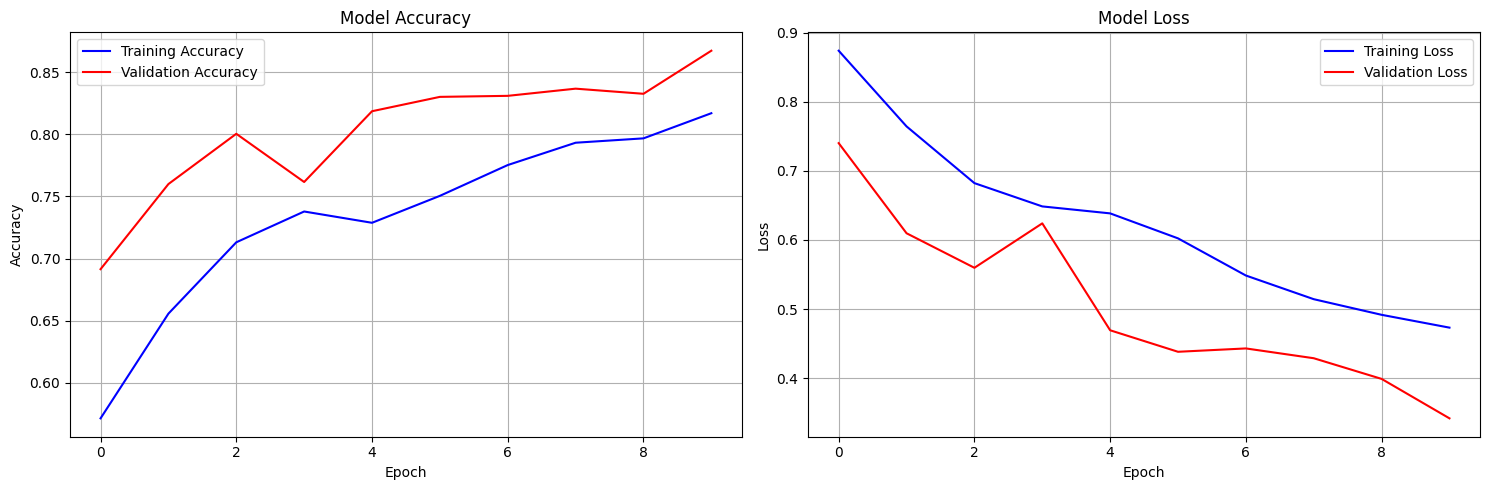

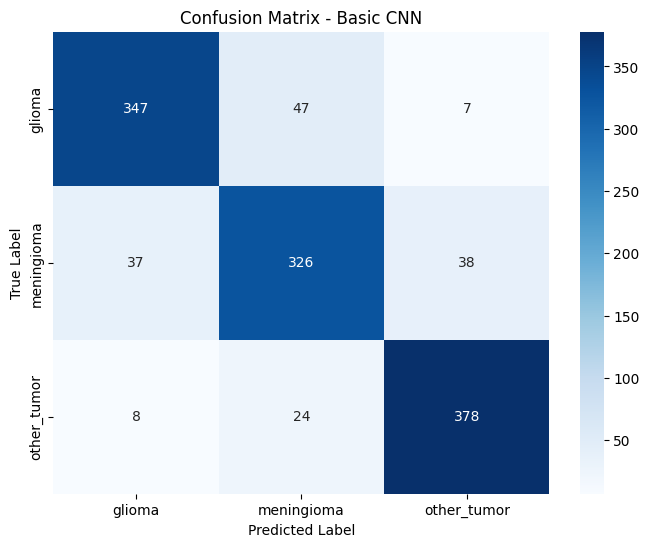


 Classification Report:
              precision    recall  f1-score   support

      glioma       0.89      0.87      0.88       401
  meningioma       0.82      0.81      0.82       401
 other_tumor       0.89      0.92      0.91       410

    accuracy                           0.87      1212
   macro avg       0.87      0.87      0.87      1212
weighted avg       0.87      0.87      0.87      1212


CNN MODEL PERFORMANS ÖZETİ
Toplam Parametre: 13,267,011
Test Accuracy: 0.8672 (86.72%)
Test Loss: 0.3418
Eğitim Epoch: 10


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


def create_advanced_cnn(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (224, 224, 3)

model = create_advanced_cnn(input_shape, num_classes)

print("MODEL MİMARİSİ:")
model.summary()

total_params = model.count_params()
print(f"Toplam Parametre Sayısı: {total_params:,}")

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]



epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)


print("\n" + "="*10)
print(" MODEL DEĞERLENDİRME")
print("="*50)

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy grafiği
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss grafiği
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Basic CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

print("\n" + "="*60)
print("CNN MODEL PERFORMANS ÖZETİ")
print("="*60)
print(f"Toplam Parametre: {total_params:,}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"Eğitim Epoch: {len(history.history['accuracy'])}")
print("="*60)

model.save('/kaggle/working/brain_cancer.h5')

MODEL MİMARİSİ:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,267,011 (50.61 MB)

 Trainable params: 13,267,011 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

Toplam Parametre Sayısı: 13,267,011
Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 66s 404ms/step - accuracy: 0.5016 - loss: 0.9676 - val_accuracy: 0.6997 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6380 - loss: 0.8067 - val_accuracy: 0.7277 - val_loss: 0.6547 - learning_rate: 0.0010
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 356ms/step - accuracy: 0.6927 - loss: 0.6926 - val_accuracy: 0.7838 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 360ms/step - accuracy: 0.7240 - loss: 0.6626 - val_accuracy: 0.8012 - val_loss: 0.4967 - learning_rate: 0.0010
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 356ms/step - accuracy: 0.7340 - loss: 0.6146 - val_accuracy: 0.7937 - val_loss: 0.5295 - learning_rate: 0.0010
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - accuracy: 0.7413 - loss: 0.6107 - val_accuracy: 0.8193 - val_loss: 0.4719 - learning_rate: 0.0010
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━

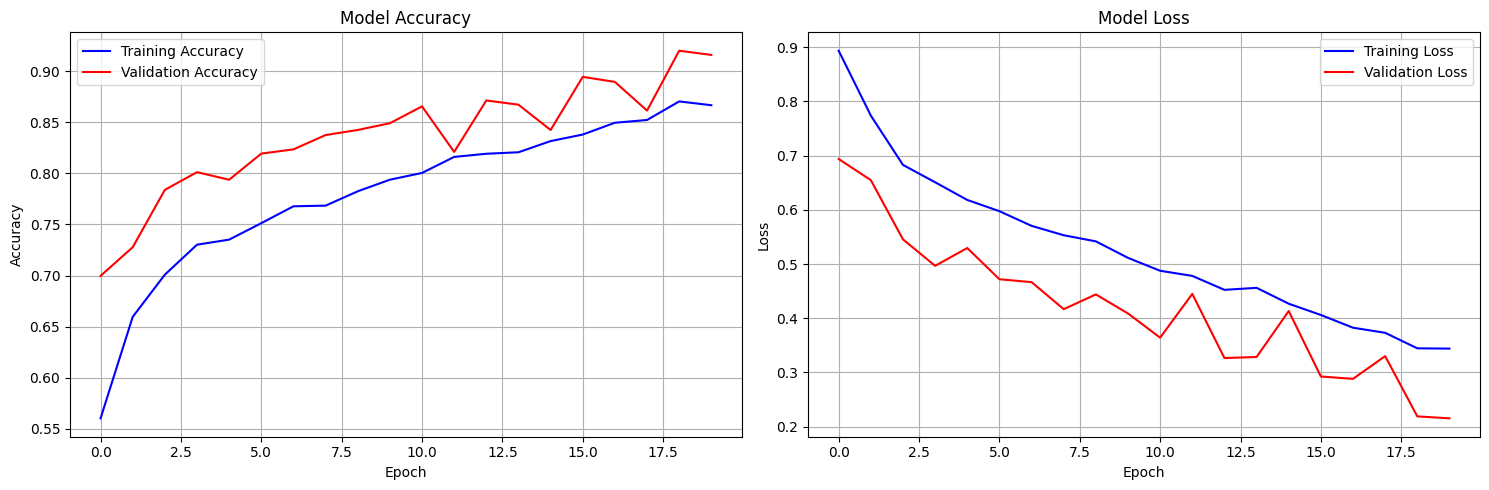

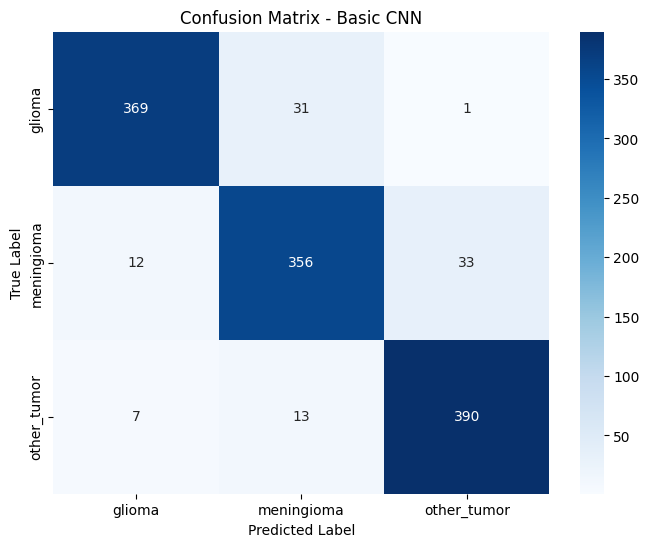


 Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.92      0.94       401
  meningioma       0.89      0.89      0.89       401
 other_tumor       0.92      0.95      0.94       410

    accuracy                           0.92      1212
   macro avg       0.92      0.92      0.92      1212
weighted avg       0.92      0.92      0.92      1212


CNN MODEL PERFORMANS ÖZETİ
Toplam Parametre: 13,267,011
Test Accuracy: 0.9200 (92.00%)
Test Loss: 0.2190
Eğitim Epoch: 20


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


def create_advanced_cnn(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (224, 224, 3)

model = create_advanced_cnn(input_shape, num_classes)

print("MODEL MİMARİSİ:")
model.summary()

total_params = model.count_params()
print(f"Toplam Parametre Sayısı: {total_params:,}")

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]



epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)


print("\n" + "="*20)
print(" MODEL DEĞERLENDİRME")
print("="*50)

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy grafiği
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss grafiği
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Basic CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

print("\n" + "="*60)
print("CNN MODEL PERFORMANS ÖZETİ")
print("="*60)
print(f"Toplam Parametre: {total_params:,}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"Eğitim Epoch: {len(history.history['accuracy'])}")
print("="*60)

model.save('/kaggle/working/brain_cancer.h5')